In [1]:
import os
import torch
import random
import tqdm
import time
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Hyper parameters
epochs = 10
lr = 1e-4
batch_size = 64
num_classes = 14 # Should NOT be changed
default_weights = ResNet18_Weights.IMAGENET1K_V1

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), # 3 channel grayscale, some images are 1 channel
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(f"Using {device} device")

seed = 16
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(f"Seed set to {seed}")


Using mps device
Seed set to 16


In [3]:
class MyDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, category = self.data[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, category

    def load_data(self):
        data = []
        with open(self.csv_file, 'r') as file:
            lines = file.readlines()
            for line in lines[1:]:
                image_path, category = line.strip().split(',')
                image_path = os.path.join('dataset', image_path)
                data.append((image_path, int(category)))
        return data

    def get_category_name(self, category):
        # get a human readable category name
        category_name = None
        for image_path, cat in self.data:
            if cat == category:
                category_name = image_path.split('/')[-2]
                break
        return category_name


In [4]:
# Load train data and validation data
train_dataset = MyDataset(csv_file='./dataset/train.csv', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MyDataset(csv_file='./dataset/val.csv', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Val dataset size:   ", len(val_dataset))
print("Train dataset size: ", len(train_dataset))
for i in range(14):
    category_name = train_dataset.get_category_name(i)
    count = len([x for x in train_dataset.data if x[1] == i])
    print(f"  {category_name.ljust(18)} {count}")


Val dataset size:    98
Train dataset size:  13642
  carnation          924
  iris               1041
  bellflower         872
  california_poppy   1021
  rose               986
  astilbe            726
  tulip              1034
  calendula          1011
  dandelion          1038
  coreopsis          1035
  black_eyed_susan   986
  water_lily         977
  sunflower          1013
  common_daisy       978


In [5]:
net = models.resnet18(weights=default_weights)
net.fc = nn.Linear(512, num_classes)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)


In [6]:
train_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(epochs):
    # Training
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    data_iter = tqdm.tqdm(
        enumerate(train_dataloader, 0),
        desc=f"Train - Epoch {epoch+1}",
        total=len(train_dataloader),
    )
    for i, data in data_iter:
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss.append(running_loss / len(train_dataloader))
    train_accuracy.append(100 * train_correct / train_total)

    # Validation
    val_correct = 0
    val_total = 0
    data_iter = tqdm.tqdm(
        enumerate(val_dataloader, 0),
        desc=f"Val - Epoch {epoch+1}",
        total=len(val_dataloader),
    )
    for i, data in data_iter:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

    val_accuracy.append(100 * val_correct / val_total)

    print(f"Epoch {epoch + 1} loss: {train_loss[-1]}")
    print(f"Training accuracy: {100 * train_correct / train_total}%")
    print(f"Validation accuracy: {100 * val_correct / val_total}%")
    print()

# Save the model as model-timestamp.pth
torch.save(net.state_dict(), f"./model-{int(time.time())}.pth")


Val - Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch 1 loss: 0.6300731374420853
Training accuracy: 81.5496261545228%
Validation accuracy: 82.65306122448979%



Val - Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


Epoch 2 loss: 0.2274610759498917
Training accuracy: 93.33675414162147%
Validation accuracy: 82.65306122448979%



Val - Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch 3 loss: 0.1309654082685152
Training accuracy: 96.41548160093828%
Validation accuracy: 88.77551020408163%



Val - Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Epoch 4 loss: 0.07257710630074143
Training accuracy: 97.98416654449494%
Validation accuracy: 88.77551020408163%



Val - Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch 5 loss: 0.045709110176295184
Training accuracy: 98.8418120510189%
Validation accuracy: 88.77551020408163%



Val - Epoch 6: 100%|██████████| 2/2 [00:00<00:00,  7.89it/s]


Epoch 6 loss: 0.04032296438866826
Training accuracy: 99.01040903093389%
Validation accuracy: 86.73469387755102%



Val - Epoch 7: 100%|██████████| 2/2 [00:00<00:00,  7.78it/s]


Epoch 7 loss: 0.02653711807269986
Training accuracy: 99.3915848116112%
Validation accuracy: 88.77551020408163%



Val - Epoch 8: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


Epoch 8 loss: 0.02439799134958988
Training accuracy: 99.31828177686556%
Validation accuracy: 85.71428571428571%



Val - Epoch 9: 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


Epoch 9 loss: 0.028398102286454535
Training accuracy: 99.24497874211993%
Validation accuracy: 84.6938775510204%



Val - Epoch 10: 100%|██████████| 2/2 [00:00<00:00,  7.92it/s]


Epoch 10 loss: 0.019480027852440688
Training accuracy: 99.53819088110248%
Validation accuracy: 87.75510204081633%



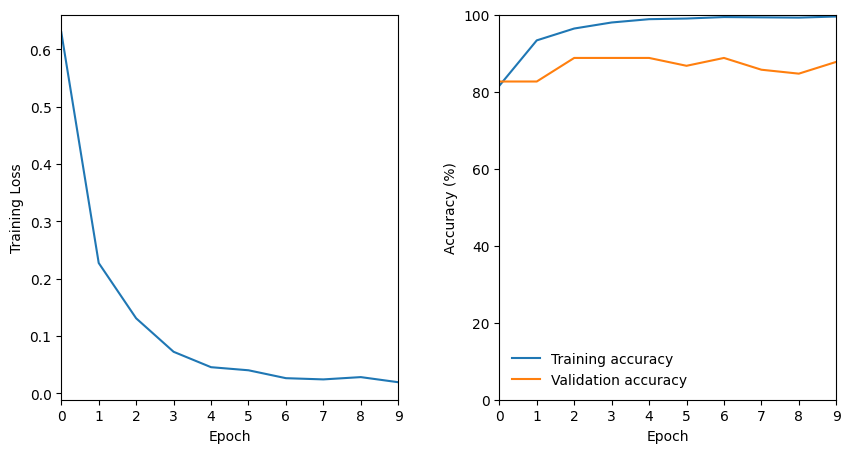

In [7]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.xlim([0, epochs - 1])
plt.xticks(range(epochs))

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 100])
plt.xlim([0, epochs - 1])
plt.xticks(range(epochs))

plt.subplots_adjust(wspace=0.3)

plt.show()
